# 技術側の分析


<a id=top></a>


<a href='#data'>データインポート</a>


---


<a id=init></a>

## **1. モジュールインポート・初期条件設定**


In [1]:
import pandas as pd
import numpy as np
import sys

sys.path.append('../../src')
from ecomplexity import ecomplexity
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import io

import matplotlib.ticker as ptick
import networkx as nx
import networkx.algorithms.bipartite as bip

plt.rcParams['font.family'] = 'Meiryo'
plt.rcParams['font.size'] = 20

# 小数点以下 桁数 6
pd.options.display.float_format = '{:.3f}'.format

In [2]:
import initial_condition
from process import weight
from visualize import rank as vr

In [3]:
global data_dir, ex_dir, output_dir
data_dir = '../../data/processed/internal/technology/'
ex_dir = '../../data/processed/external/'
output_dir = '../../output/figures/'

In [4]:
# 初期条件
ar = initial_condition.AR
year_style = initial_condition.YEAR_STYLE

year_start = initial_condition.YEAR_START
year_end = initial_condition.YEAR_END
year_range = initial_condition.YEAR_RANGE

extract_population = initial_condition.EXTRACT_POPULATION
top_p_or_num = initial_condition.TOP_P_OR_NUM
region_corporation = initial_condition.REGION_CORPORATION
applicant_weight = initial_condition.APPLICANT_WEIGHT

classification = initial_condition.CLASSIFICATION
class_weight = initial_condition.CLASS_WEIGHT

color_list = initial_condition.COLOR_LIST

input_condition = f'{ar}_{year_style}_{extract_population}_{top_p_or_num[0]}_{top_p_or_num[1]}_{region_corporation}_{applicant_weight}_{classification}_{class_weight}'
fig_name_base = f'{ar}_{year_style}_{extract_population}_{top_p_or_num[0]}_{top_p_or_num[1]}_{region_corporation}_{applicant_weight}_{classification}_{class_weight}.png'


In [5]:
# 条件確認
input_condition

'app_nendo_all_p_3_right_person_name_fraction_schmoch35_fraction'

In [6]:
period_order_dict = {
    f'{period_start}-{period_start+year_range-1}': i
    for i, period_start in enumerate(range(year_start, year_end + 1, year_range))
}

period_order_dict[f'{year_start}-{year_end}'] = len(period_order_dict)
period_order_dict

{'1981-1990': 0, '1991-2000': 1, '2001-2010': 2, '1981-2010': 3}

<a href=#top>TOP に戻る</a>

---


<a id='data'></a>

## **2. データインポート**


In [7]:
jp_df = pd.read_csv(f'{data_dir}{input_condition}.csv', 
                    encoding='utf-8',
                    sep=','
                    )

# schmoch_df = pd.read_csv(f'{ex_dir}schmoch/35.csv', 
#                          encoding='utf-8', 
#                          sep=',', 
#                          usecols=['Field_number', 'Field_en']).drop_duplicates()

# jp_df = pd.merge(jp_df, schmoch_df, left_on=classification, right_on='Field_number', how='left')\
#         .drop(columns=['Field_number', classification])\
#         .rename(columns={'Field_en': classification})\
#         .sort_values(f'{ar}_{year_style}_period', key=lambda col: col.map(period_order_dict))
jp_df = jp_df.sort_values(f'{ar}_{year_style}_period', key=lambda col: col.map(period_order_dict))

eu_df = pd.read_csv(f'{ex_dir}abroad/eu.csv', 
                    encoding='utf-8', 
                    sep=',')
eu_df


schmoch35                schmoch5  \
0                     Digital communication  Electrical engineering   
1                        Telecommunications  Electrical engineering   
2                       Computer technology  Electrical engineering   
3                   Audio-visual technology  Electrical engineering   
4                 IT methods for management  Electrical engineering   
5                           Pharmaceuticals               Chemistry   
6                    Organic fine chemistry               Chemistry   
7             Basic communication processes  Electrical engineering   
8                                    Optics             Instruments   
9                            Semiconductors  Electrical engineering   
10                            Biotechnology             Instruments   
11                       Medical technology  Electrical engineering   
12     Micro-structural and nano-technology               Chemistry   
13                              Measurement             Instruments   
14                           Food chemistry               Chemistry   
15                                  Control             Instruments   
16                         Furniture, games            Other fields   
17                Basic materials chemistry               Chemistry   
18                     Chemical engineering               Chemistry   
19                 Environmental technology               Chemistry   
20       Macromolecular chemistry, polymers               Chemistry   
21                 Engines, pumps, turbines  Mechanical engineering   
22  Electrical machinery, apparatus, energy  Electrical engineering   
23               Textile and paper machines  Mechanical engineering   
24                     Other consumer goods            Other fields   
25                        Civil engineering            Other fields   
26                    Materials, metallurgy               Chemistry   
27                   Other special machines  Mechanical engineering   
28          Thermal processes and apparatus  Mechanical engineering   
29              Surface technology, coating               Chemistry   
30                                Transport  Mechanical engineering   
31                                 Handling  Mechanical engineering   
32                      Mechanical elements  Mechanical engineering   

    reg_num_eu  TCI_eu     period  
0        24566 100.000  1985-2009  
1        34007  96.970  1985-2009  
2        34246  93.940  1985-2009  
3        21662  90.910  1985-2009  
4         5565  87.880  1985-2009  
5        62999  84.850  1985-2009  
6        99687  81.820  1985-2009  
7         6284  78.790  1985-2009  
8        17771  75.760  1985-2009  
9        17315  72.730  1985-2009  
10       38361  69.700  1985-2009  
11       46350  66.670  1985-2009  
12        2481  63.640  1985-2009  
13       60591  60.610  1985-2009  
14       14635  57.580  1985-2009  
15       17246  54.550  1985-2009  
16       17389  51.520  1985-2009  
17       43406  48.480  1985-2009  
18       38982  45.450  1985-2009  
19       10611  42.420  1985-2009  
20       34069  39.390  1985-2009  
21       38953  36.360  1985-2009  
22       57052  33.330  1985-2009  
23       21638  30.300  1985-2009  
24       20302  27.270  1985-2009  
25       32346  24.240  1985-2009  
26       23955  21.210  1985-2009  
27       37208  18.180  1985-2009  
28       23146  15.150  1985-2009  
29       18977  12.120  1985-2009  
30       58920   9.090  1985-2009  
31       60120   6.060  1985-2009  
32       38604   3.030  1985-2009

In [8]:
eu_jp_df = pd.merge(jp_df[jp_df[f'{ar}_{year_style}_period']==f'{year_start}-{year_end}'][[classification, 'tci', 'reg_num']], 
                    eu_df[[classification, 'TCI_eu', 'reg_num_eu']], 
                    on=classification, how='inner').rename(columns={'tci': 'TCI_jp', 'reg_num': 'reg_num_jp'})
eu_jp_df['TCI_jp'] = (eu_jp_df['TCI_jp'] - eu_jp_df['TCI_jp'].min()) / (eu_jp_df['TCI_jp'].max() - eu_jp_df['TCI_jp'].min()) * 100
eu_jp_df = eu_jp_df.sort_values('TCI_jp', ascending=False).reset_index(drop=True)


In [14]:
jp_df[~jp_df['schmoch35'].isin(eu_df['schmoch35'])]['schmoch35'].unique()

array(['Machine tools', 'Analysis of biological materials'], dtype=object)

In [13]:
eu_jp_df

schmoch35  TCI_jp  reg_num_jp  TCI_eu  \
0                     Digital communication 100.000   37687.500 100.000   
1                       Computer technology  84.183  156940.833  93.940   
2                        Telecommunications  76.551  103302.500  96.970   
3             Basic communication processes  74.818   36129.500  78.790   
4                                    Optics  63.806  217287.333  75.760   
5                                   Control  47.182   57282.500  54.550   
6                   Audio-visual technology  45.192  193028.000  90.910   
7                            Semiconductors  43.775  144129.333  72.730   
8                               Measurement  41.087  174278.500  60.610   
9   Electrical machinery, apparatus, energy  37.018  234113.000  33.330   
10               Textile and paper machines  35.762  108695.500  30.300   
11                IT methods for management  29.369   11300.000  87.880   
12                 Engines, pumps, turbines  29.167  100919.833  36.360   
13     Micro-structural and nano-technology  24.302     814.000  63.640   
14                                Transport  22.514  145420.833   9.090   
15                                 Handling  20.298  114658.333   6.060   
16                       Medical technology  14.409   71204.000  66.670   
17          Thermal processes and apparatus  10.399   73353.000  15.150   
18                           Food chemistry  10.239   30706.000  57.580   
19                            Biotechnology   8.465   23786.000  69.700   
20                   Organic fine chemistry   8.336   55168.333  81.820   
21                         Furniture, games   8.176  111070.000  51.520   
22                      Mechanical elements   7.550   85323.500   3.030   
23                     Other consumer goods   7.344   56896.000  27.270   
24              Surface technology, coating   7.289   78793.833  12.120   
25                    Materials, metallurgy   5.892  107262.333  21.210   
26                   Other special machines   4.323  119763.667  18.180   
27                Basic materials chemistry   3.988   57241.167  48.480   
28                     Chemical engineering   3.886   61078.500  45.450   
29       Macromolecular chemistry, polymers   2.857   77996.833  39.390   
30                          Pharmaceuticals   1.773   18263.500  84.850   
31                        Civil engineering   0.535  153258.000  24.240   
32                 Environmental technology   0.000   52051.333  42.420   

    reg_num_eu  
0        24566  
1        34246  
2        34007  
3         6284  
4        17771  
5        17246  
6        21662  
7        17315  
8        60591  
9        57052  
10       21638  
11        5565  
12       38953  
13        2481  
14       58920  
15       60120  
16       46350  
17       23146  
18       14635  
19       38361  
20       99687  
21       17389  
22       38604  
23       20302  
24       18977  
25       23955  
26       37208  
27       43406  
28       38982  
29       34069  
30       62999  
31       32346  
32       10611

1981-2010 0.605


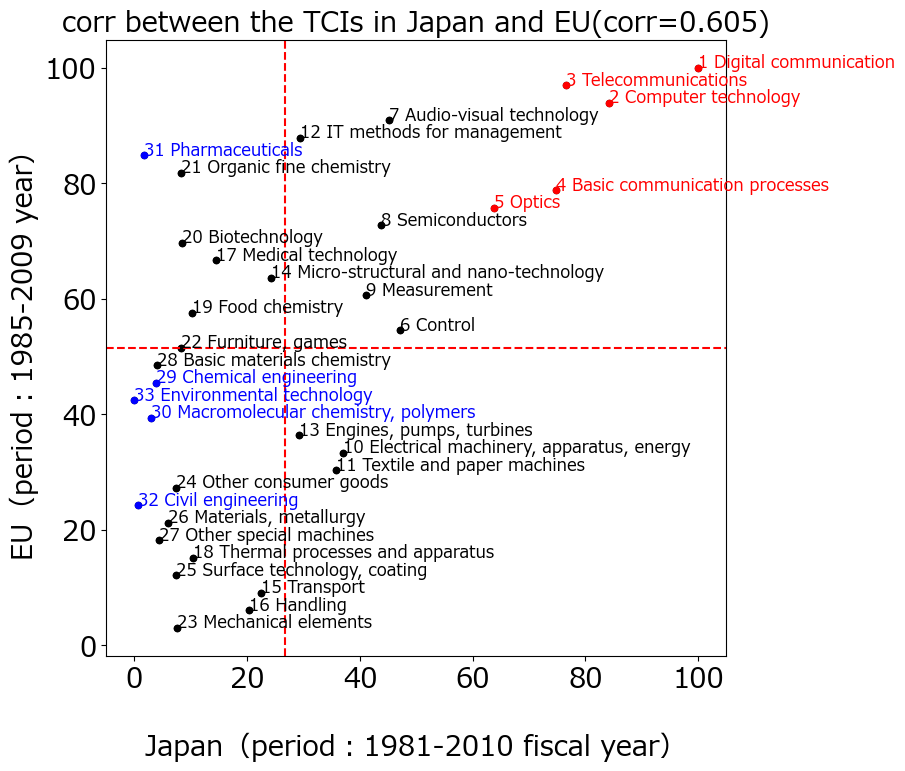

1981-2010 0.201


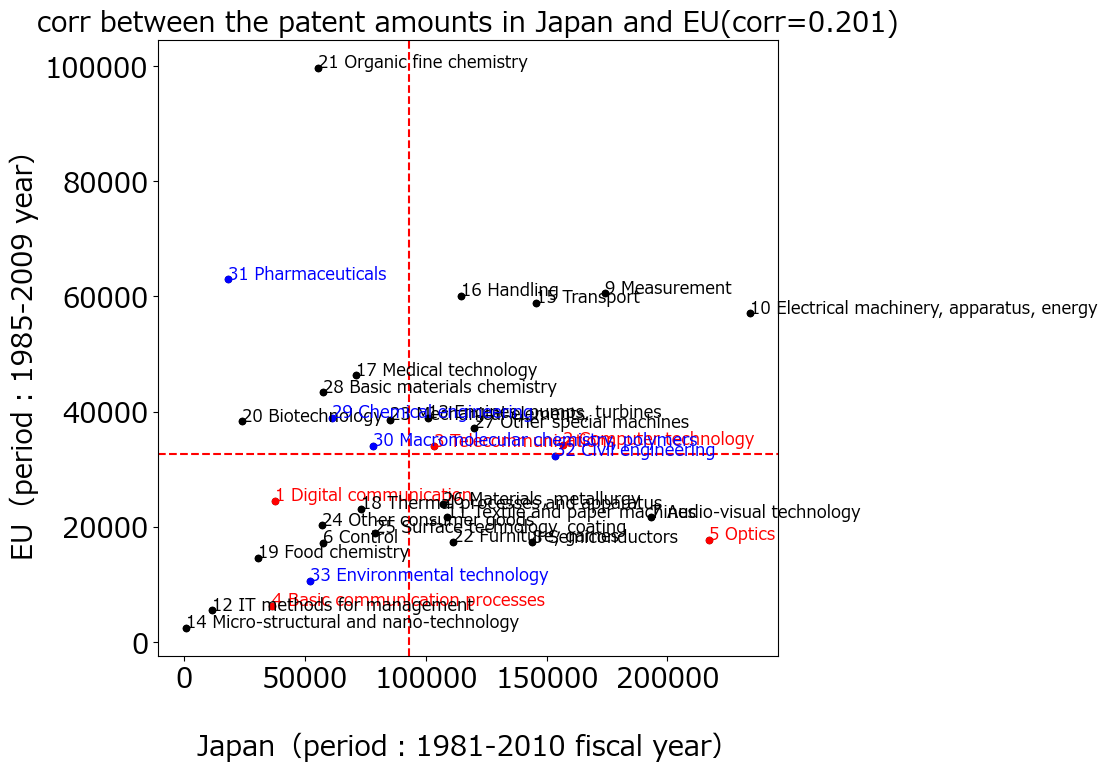

1981-2010 0.255


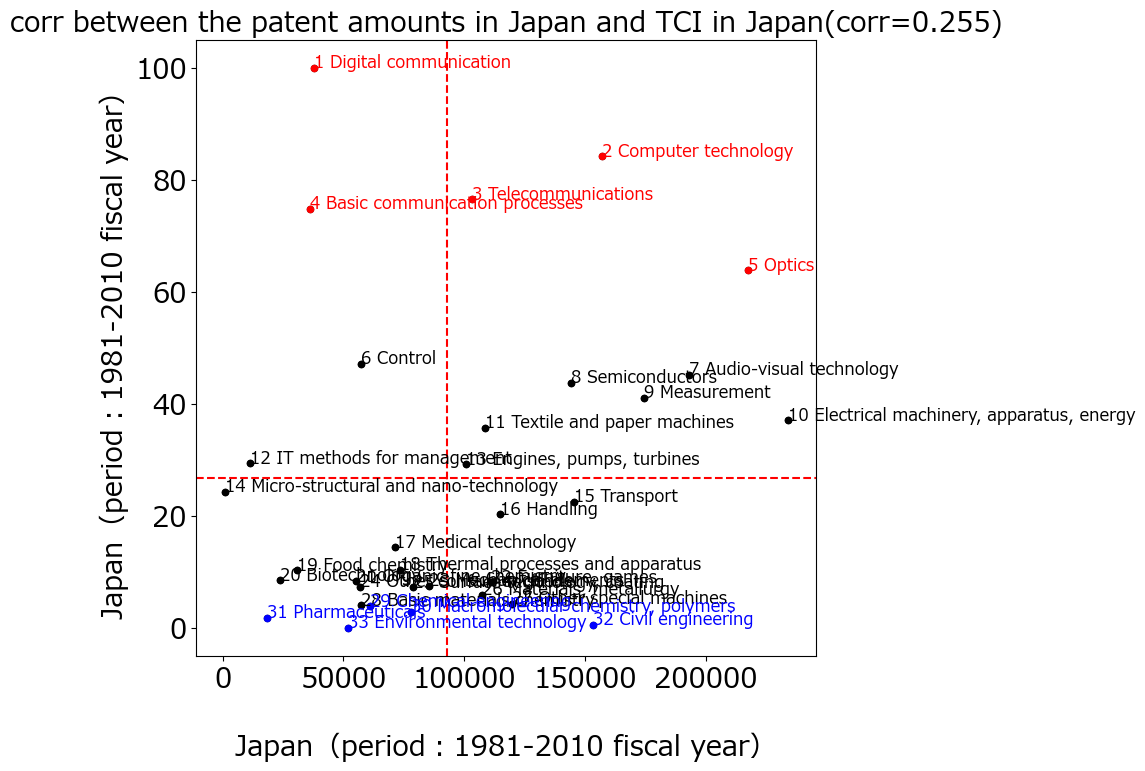

1981-2010 -0.08


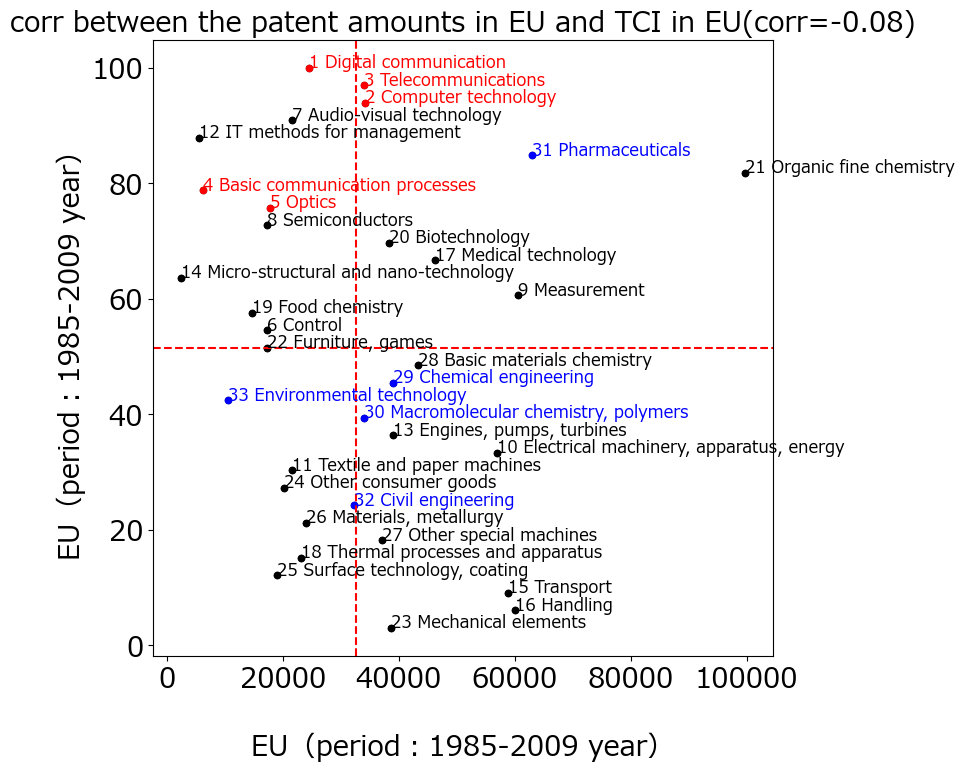

In [14]:
df_dict = {}
combi_dict = {  # ind: [x, y, title, xlabel, ylabel, legend_loc]
    1: ["TCI_jp", "TCI_eu", "corr between the TCIs in Japan and EU", "Japan（period：1981-2010 fiscal year）", "EU（period：1985-2009 year）", "center", ],
    2: ["reg_num_jp", "reg_num_eu", "corr between the patent amounts in Japan and EU", "Japan（period：1981-2010 fiscal year）", "EU（period：1985-2009 year）", "center", ],
    3: ["reg_num_jp", "TCI_jp", "corr between the patent amounts in Japan and TCI in Japan", "Japan（period：1981-2010 fiscal year）", "Japan（period：1981-2010 fiscal year）", "center", ],
    4: ["reg_num_eu", "TCI_eu", "corr between the patent amounts in EU and TCI in EU", "EU（period：1985-2009 year）", "EU（period：1985-2009 year）", "center", ],
    # 2: ["TCI_eu", "TCI_jp", "corr between the TCIs in Japan and EU", "EU（period：1985-2009 year）", "Japan（period：1981-2010 fiscal year）", "center", ],
}
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Meiryo'
for i, combi in combi_dict.items():
    fig, ax = plt.subplots(figsize=(8, 8))
    period = f"{year_start}-{year_end}"
    corr_num = round(eu_jp_df[combi[0]].corr(eu_jp_df[combi[1]]), 3)
    print(period, corr_num)
    ax.scatter(eu_jp_df[combi[0]], eu_jp_df[combi[1]],
               s=20, alpha=0.8, color="black", )
    # if i == 4:
    ax.axvline(x=eu_jp_df[combi[0]].mean(), color="red", linestyle="--", )
    ax.axhline(y=eu_jp_df[combi[1]].mean(), color="red", linestyle="--", )
    ax.set_title(combi[2]+f'(corr={corr_num})', fontsize=20)
    if combi[0] in ["reg_num"]: ax.set_xscale("log")
    if combi[1] in ["reg_num"]: ax.set_yscale("log")
    x_min = eu_jp_df[combi[0]].min()
    x_2smallest = (eu_jp_df[combi[0]].nsmallest(2).iloc[1])
    y_2smallest = (eu_jp_df[combi[1]].nsmallest(2).iloc[1])
    head_df = eu_jp_df.head(5)
    between_df = eu_jp_df.iloc[5:len(eu_jp_df)-5, :]
    tail_df = eu_jp_df.tail(5)
    if i != 5:
        for i, row in head_df.iterrows():
            ax.text(row[combi[0]], row[combi[1]], f'{i+1} {row["schmoch35"]}', fontsize=12, color="red")
            ax.scatter(row[combi[0]], row[combi[1]], s=20, color="red")
        for i, row in between_df.iterrows():
            ax.text(row[combi[0]], row[combi[1]], f'{i+1} {row["schmoch35"]}', fontsize=12, color="black")
            ax.scatter(row[combi[0]], row[combi[1]], s=20, color="black")
        for i, row in tail_df.iterrows():
            ax.text(row[combi[0]], row[combi[1]], f'{i+1} {row["schmoch35"]}', fontsize=12, color="blue", )
            ax.scatter(row[combi[0]], row[combi[1]], s=20, color="blue")
    elif i == 2:
        for i, row in head_df.iterrows():
            ax.text(row[combi[0]], row[combi[1]], i+1, fontsize=12, color="red")
            ax.scatter(row[combi[0]], row[combi[1]], s=20, color="red")
        for i, row in between_df.iterrows():
            ax.text(row[combi[0]], row[combi[1]], i+1, fontsize=12, color="black")
            ax.scatter(row[combi[0]], row[combi[1]], s=20, color="black")
        for i, row in tail_df.iterrows():
            ax.text(row[combi[0]], row[combi[1]], i+1, fontsize=12, color="blue", )
            ax.scatter(row[combi[0]], row[combi[1]], s=20, color="blue")
    ax.set_ylabel(combi[4], fontsize=20)
    ax.set_xlabel('\n'+combi[3], fontsize=20)
    # ax.legend(loc=combi[5], fontsize=20, bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.show()


In [63]:
sample_df = eu_jp_df.copy()
sample_df_dict = {
    "0": sample_df.melt(id_vars=[classification], value_vars=["TCI_jp", "TCI_eu"]).sort_values(
        ["variable", "value"], ascending=[False, False])
}
sample_df_dict['0']


schmoch35 variable   value
0                      Pharmaceuticals   TCI_jp 100.000
1               Organic fine chemistry   TCI_jp  98.976
2                       Food chemistry   TCI_jp  96.063
3                        Biotechnology   TCI_jp  94.655
4   Macromolecular chemistry, polymers   TCI_jp  93.814
..                                 ...      ...     ...
46     Thermal processes and apparatus   TCI_eu  15.150
42         Surface technology, coating   TCI_eu  12.120
51                           Transport   TCI_eu   9.090
48                            Handling   TCI_eu   6.060
47                 Mechanical elements   TCI_eu   3.030

[66 rows x 3 columns]

([<matplotlib.axis.XTick at 0x21f97d90290>,
 [Text(0, 0, 'Japan'), Text(1, 0, 'EU')])

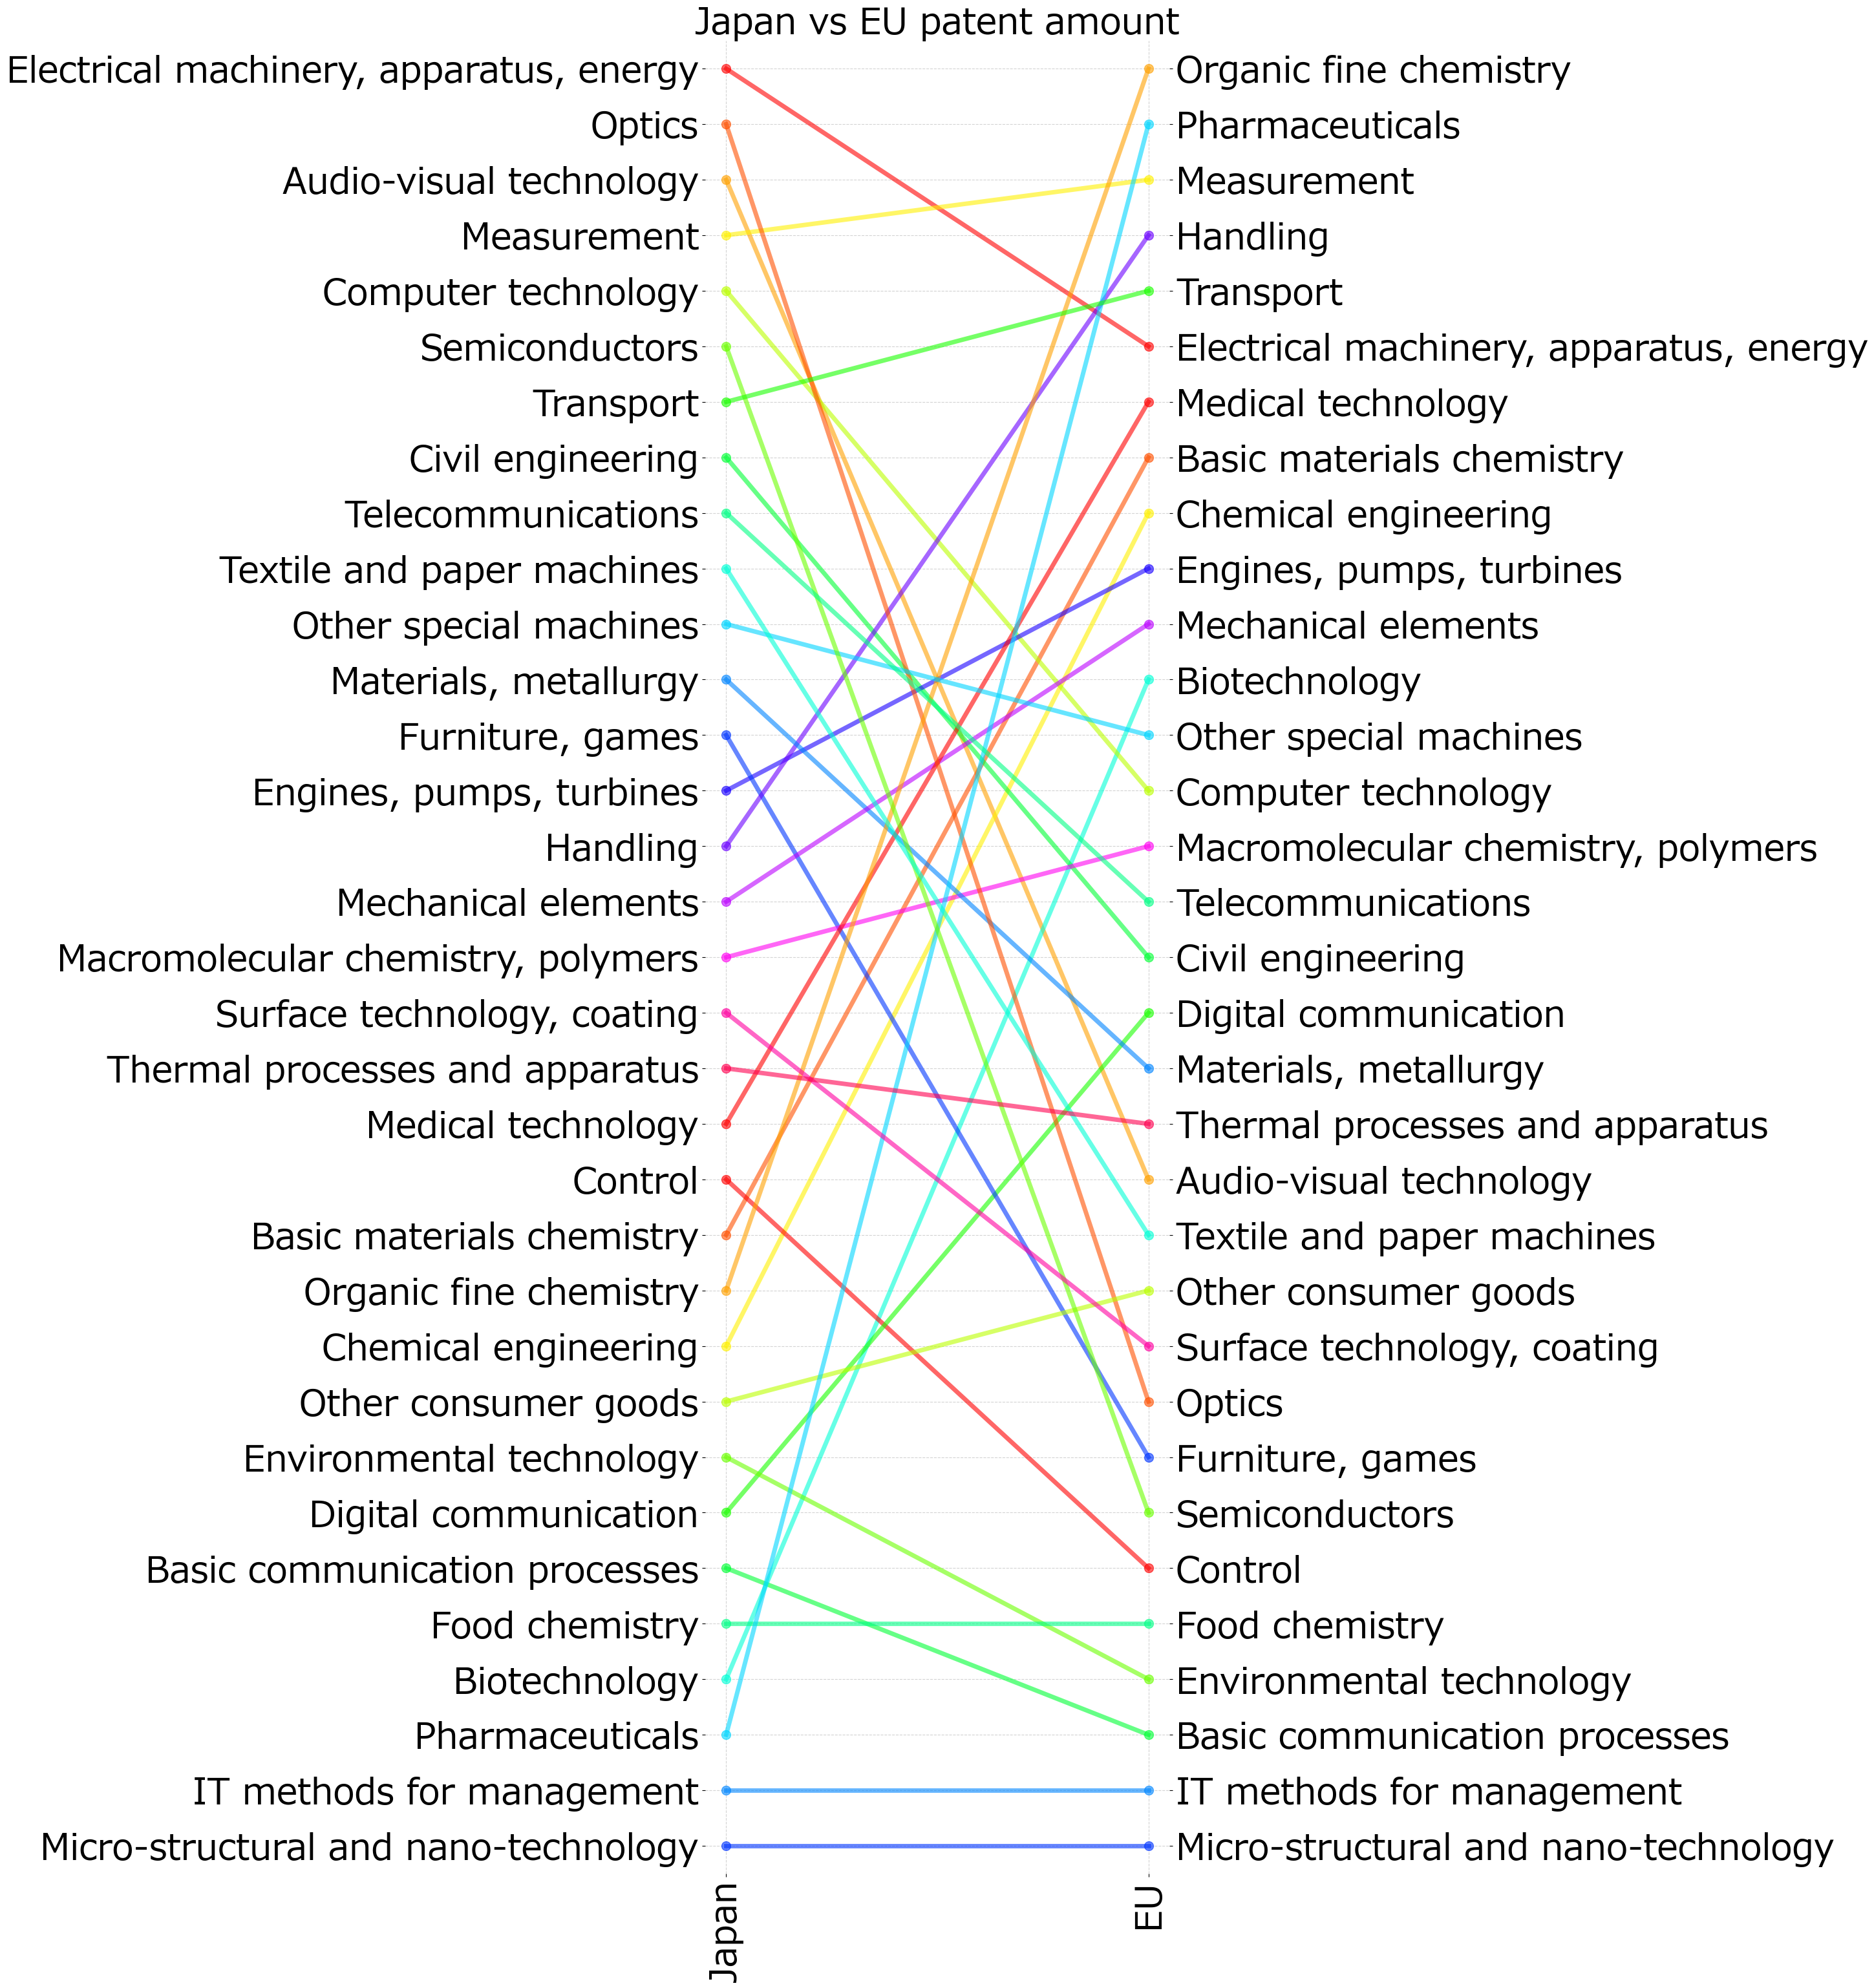

In [98]:
sample_df = eu_jp_df.copy()
sample_melt_df = sample_df.melt(id_vars=[classification], value_vars=["reg_num_jp", "reg_num_eu"]).sort_values(
        ["variable", "value"], ascending=[False, False])
sample_df_dict = {
    "0": sample_melt_df[sample_melt_df['variable']=='reg_num_jp'], 
    "1": sample_melt_df[sample_melt_df['variable']=='reg_num_eu'],
}



fs = (30, 30)

sample = vr.rank_doubleaxis(
    sample_df_dict,
    version="kci",
    rank_num=33,
    member_col=classification,
    num_col="value",
    prop_dict={
        "figsize": fs,
        "xlabel": "",
        "ylabel": "",
        "title": "",
        "fontsize": 40,
        "year_range": 1,
        "ascending": False,
        # 'color': color_dict
        "color": "default",
    },
)
plt.title("Japan vs EU patent amount", fontsize=40)
plt.xticks(range(0, 2), ['Japan', 'EU'], rotation=90)

([<matplotlib.axis.XTick at 0x21f97bbb610>,
 [Text(0, 0, 'Japan'), Text(1, 0, 'EU')])

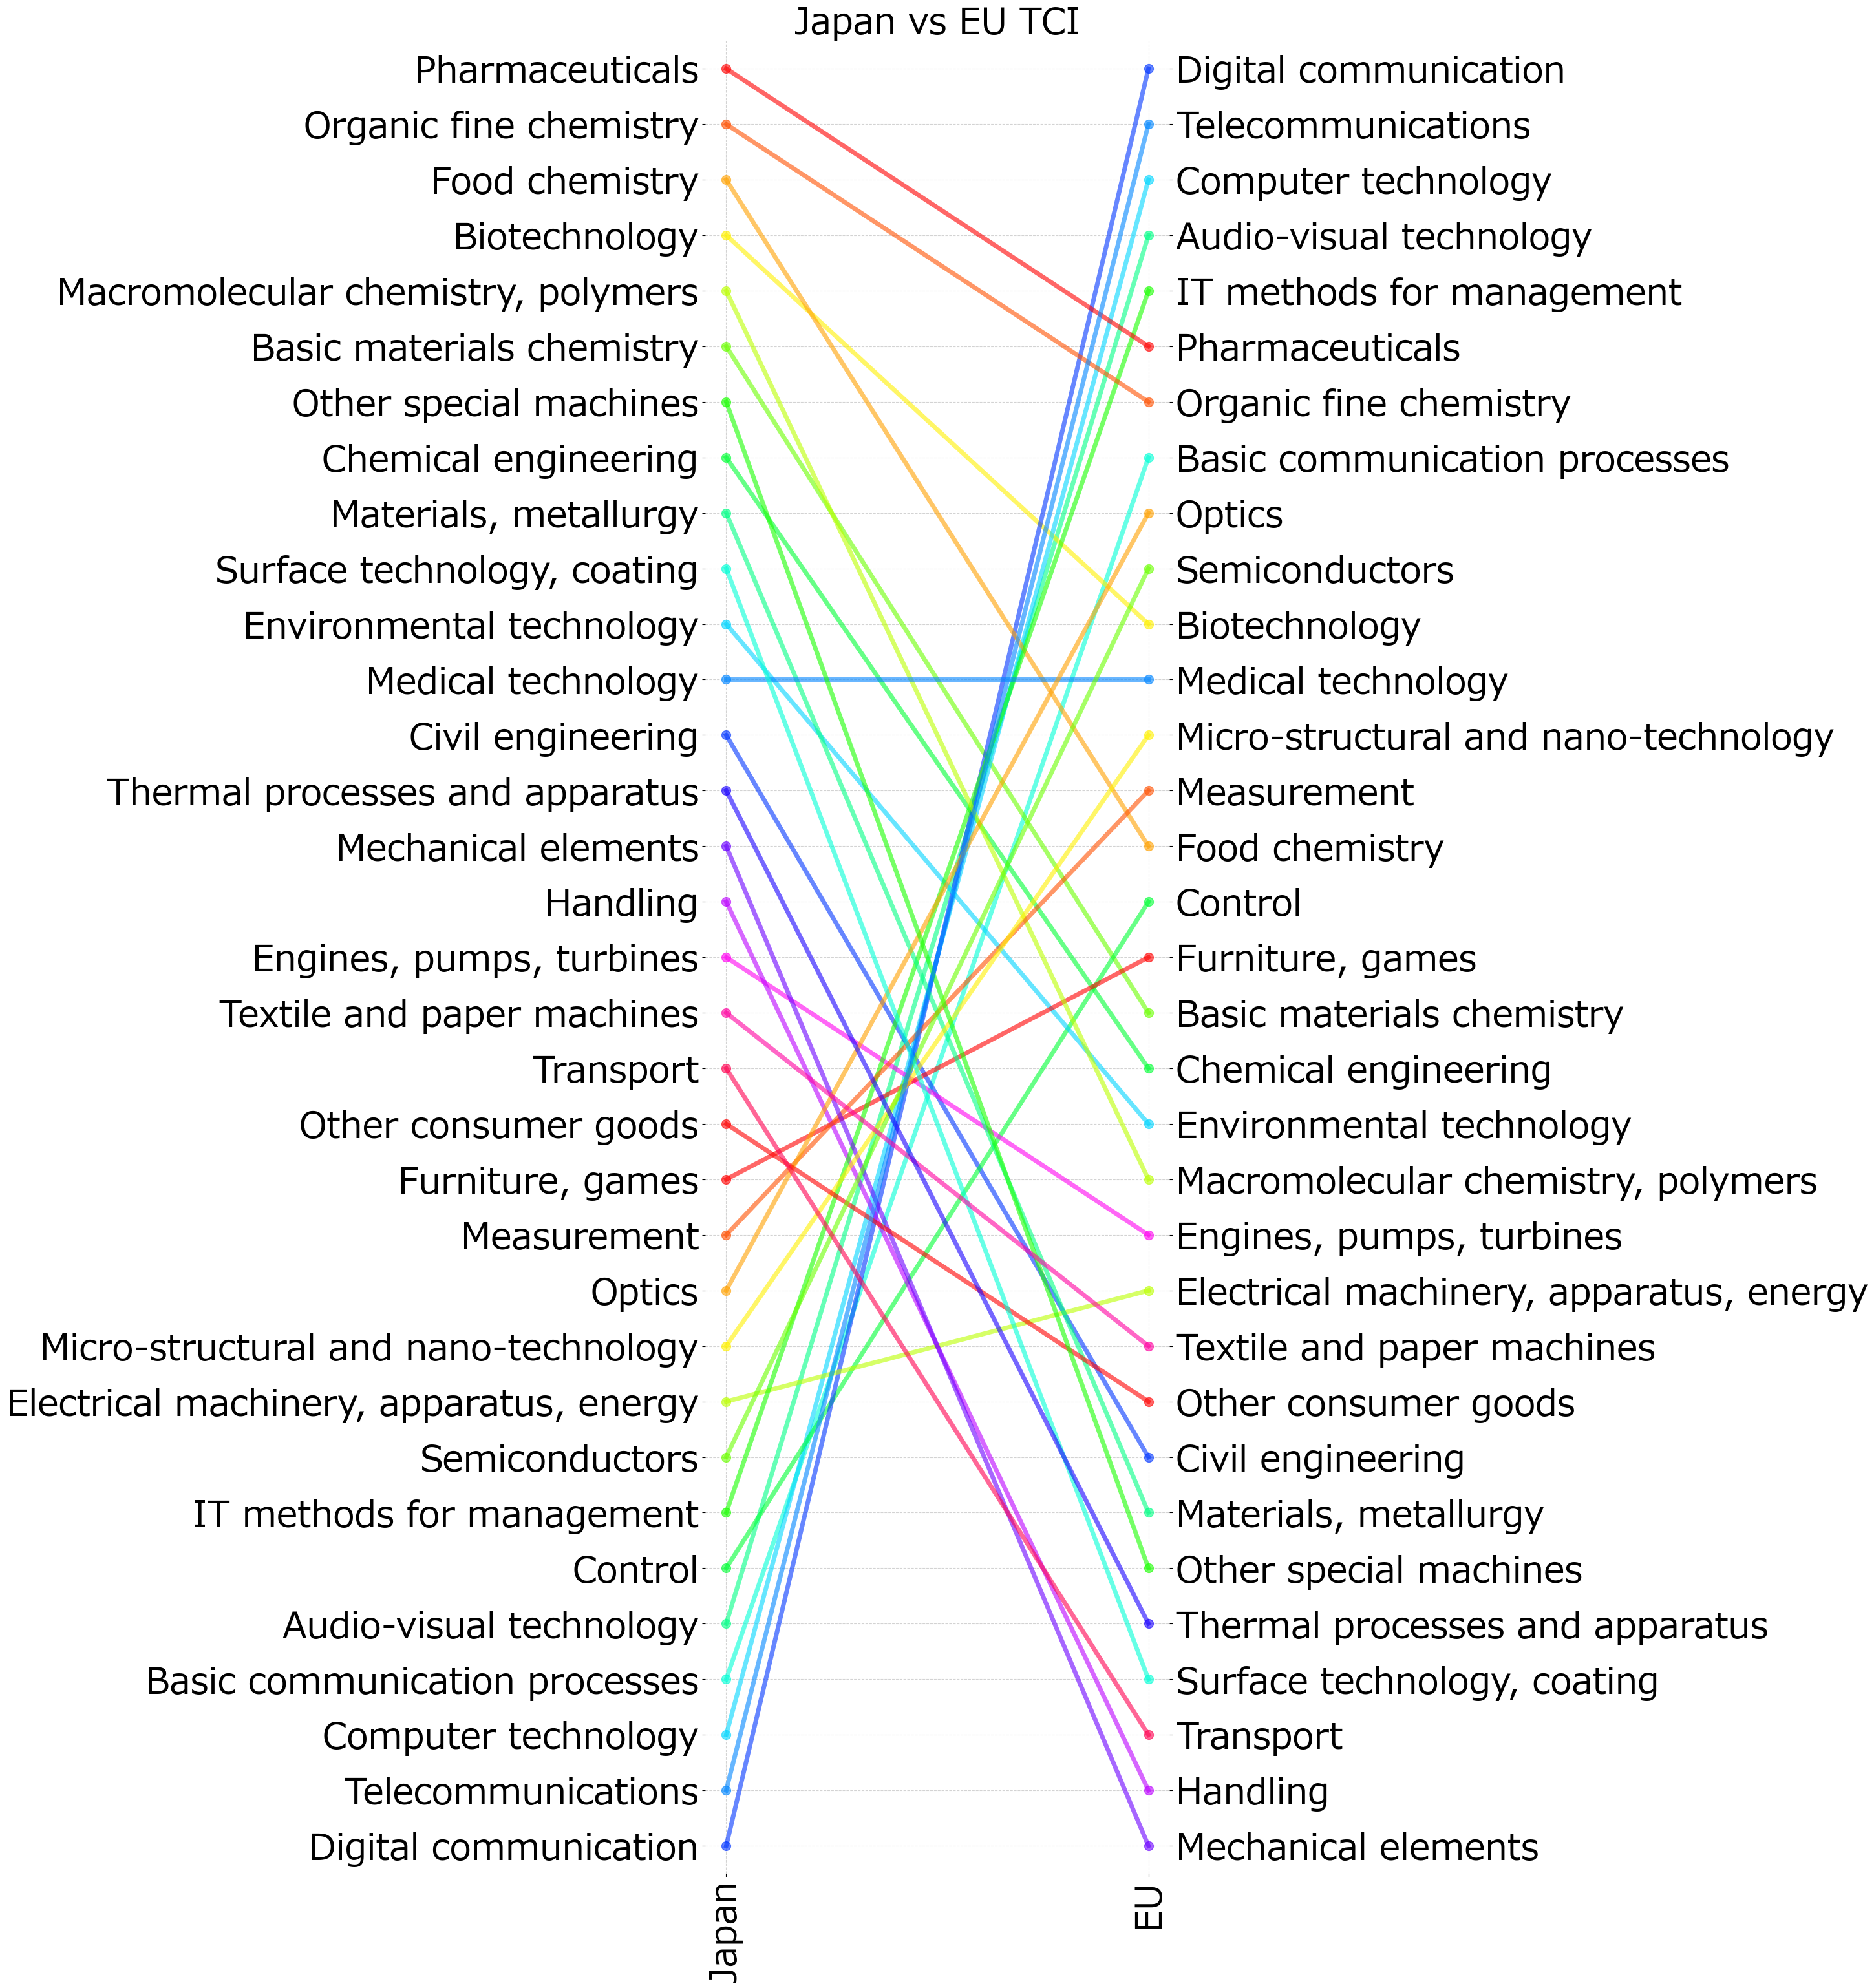

In [99]:
sample_df = eu_jp_df.copy()
sample_melt_df = sample_df.melt(id_vars=[classification], value_vars=["TCI_jp", "TCI_eu"]).sort_values(
        ["variable", "value"], ascending=[False, False])
sample_df_dict = {
    "0": sample_melt_df[sample_melt_df['variable']=='TCI_jp'], 
    "1": sample_melt_df[sample_melt_df['variable']=='TCI_eu'],
}



fs = (30, 30)

sample = vr.rank_doubleaxis(
    sample_df_dict,
    version="kci",
    rank_num=33,
    member_col=classification,
    num_col="value",
    prop_dict={
        "figsize": fs,
        "xlabel": "",
        "ylabel": "",
        "title": "",
        "fontsize": 40,
        "year_range": 1,
        "ascending": False,
        # 'color': color_dict
        "color": "default",
    },
)
plt.title("Japan vs EU TCI", fontsize=40)

plt.xticks(range(0, 2), ['Japan', 'EU'], rotation=90)

Text(0, 0.5, 'TCI_eu（1985-2009 year）')

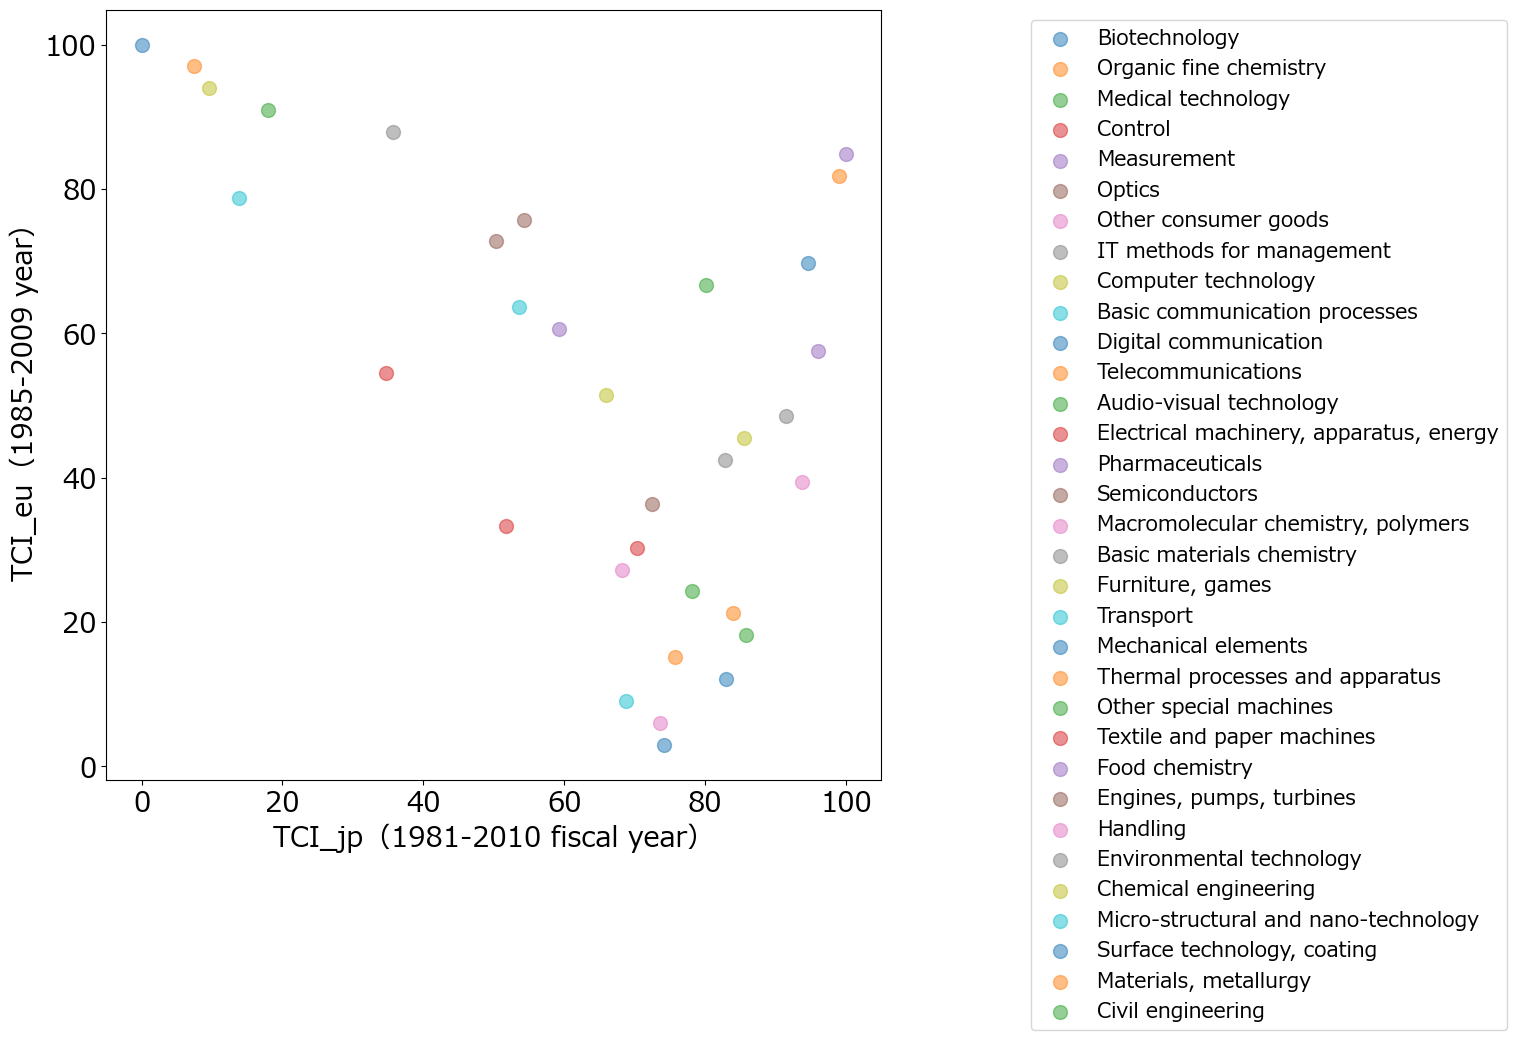

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
# sns.scatterplot(data=eu_jp_df, x='TCI_jp', y='TCI_eu', hue=classification, ax=ax, s=100)
for schmoch in eu_jp_df.head(5)[classification].unique():
    ax.scatter(eu_jp_df[eu_jp_df[classification]==schmoch]['TCI_jp'], 
               eu_jp_df[eu_jp_df[classification]==schmoch]['TCI_eu'], 
               s=100, alpha=0.5, label=schmoch)

for schmoch in eu_jp_df.loc[, classification].unique():
    ax.scatter(eu_jp_df[eu_jp_df[classification]==schmoch]['TCI_jp'], 
               eu_jp_df[eu_jp_df[classification]==schmoch]['TCI_eu'], 
               s=100, alpha=0.5, label=schmoch)

for schmoch in eu_jp_df.tail(5)[classification].unique():
    ax.scatter(eu_jp_df[eu_jp_df[classification]==schmoch]['TCI_jp'], 
               eu_jp_df[eu_jp_df[classification]==schmoch]['TCI_eu'], 
               s=100, alpha=0.5, label=schmoch)
# ax.scatter(eu_jp_df['TCI_jp'], eu_jp_df['TCI_eu'], 
#            s=100, alpha=0.5)

ax.legend(list(eu_jp_df[classification]), fontsize=15, loc='upper center', bbox_to_anchor=(1.5, 1))
ax.set_xlabel('TCI_jp（1981-2010 fiscal year）')
ax.set_ylabel('TCI_eu（1985-2009 year）')

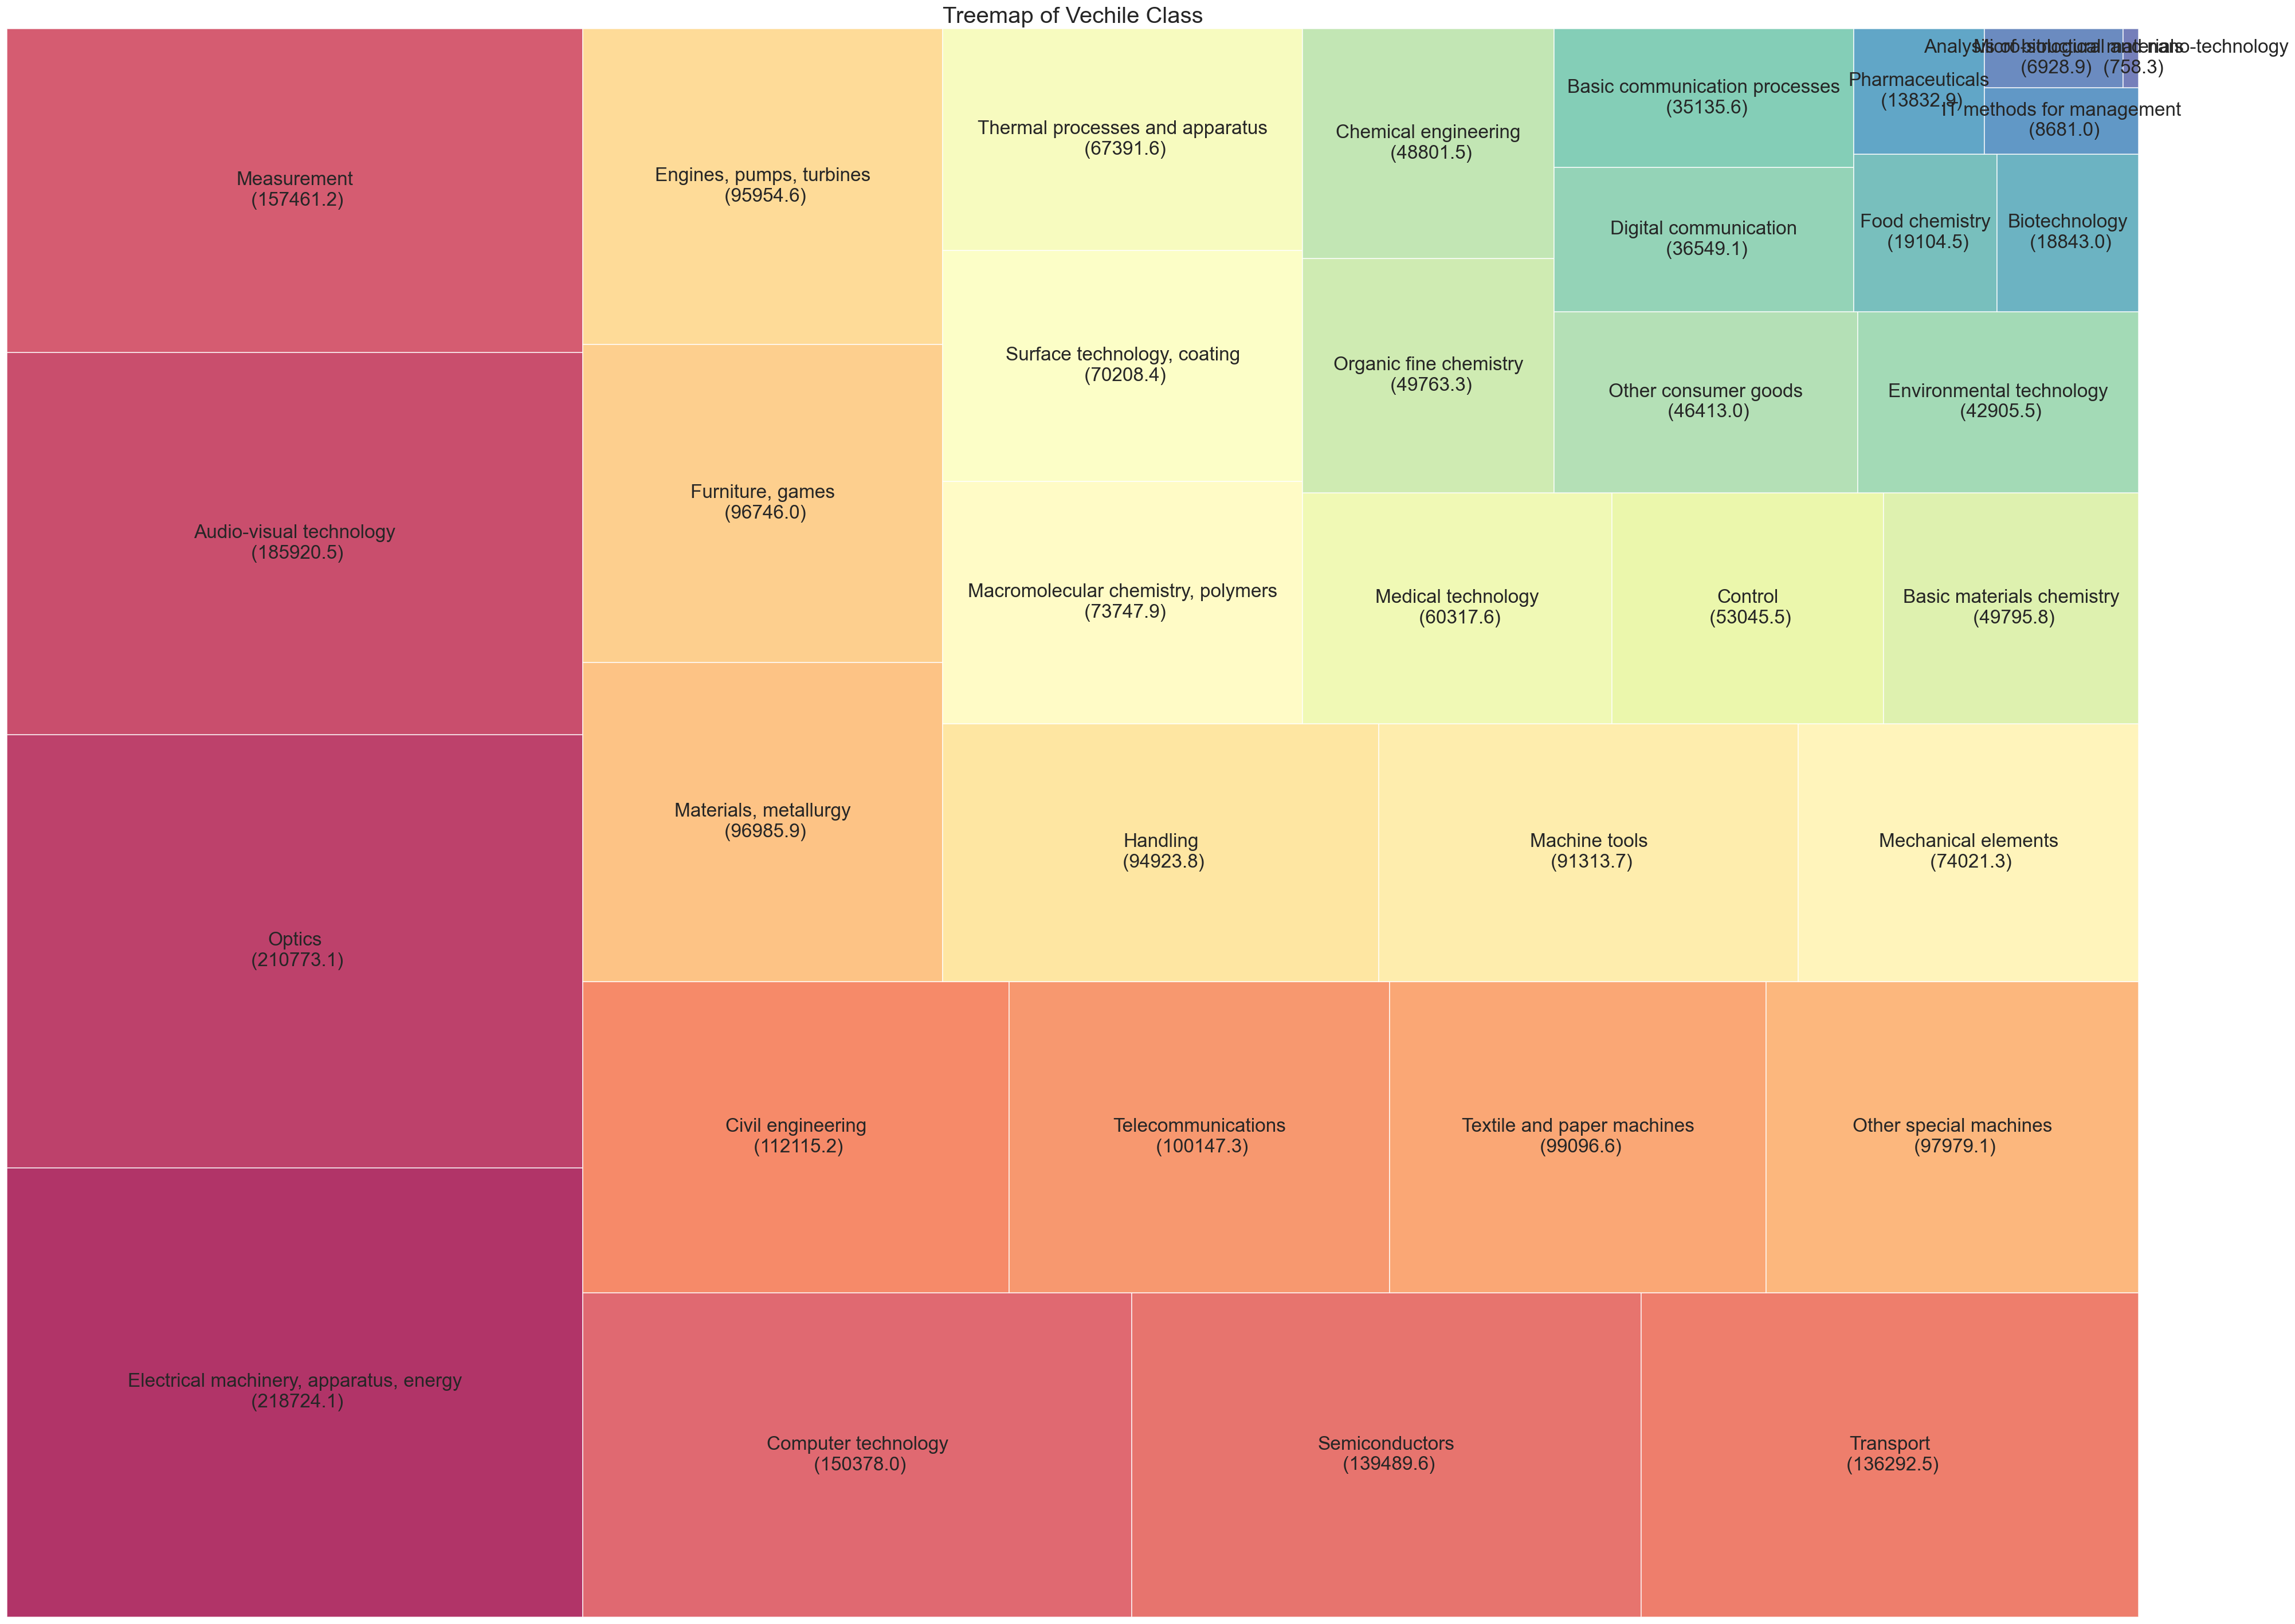

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import squarify

sns.set_style('darkgrid')
df_2col = df[df[f'{ar}_{year_style}_period'] == f'{year_start}-{year_end}'][
    ['schmoch35', 'reg_num']
].sort_values('reg_num', ascending=False)
# df_raw = pd.read_csv('https://github.com/selva86/datasets/raw/master/import squarify.csv')

# df_raw = pd.read_csv('https://github.com/selva86/datasets/raw/master/mpg_ggplot2.csv')
# display(df_raw)
# display(df_raw.groupby('class').size().reset_index(name='counts'))
labels = df_2col.apply(lambda x: str(x[0]) + '\n (' + str(round(x[1], 1)) + ')', axis=1)
sizes = df_2col['reg_num'].values.tolist()
colors = [plt.cm.Spectral(i / float(len(labels))) for i in range(len(labels))]
# colors = color_list
# display(sizes)
plt.figure(figsize=(40, 30), dpi=120)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8)

plt.title('Treemap of Vechile Class')
plt.axis('off')
plt.show()